In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn import preprocessing
from e2ml.experimentation import perform_bayesian_optimization
from e2ml.preprocessing import PrincipalComponentAnalysis, StandardScaler
from sklearn.decomposition import PCA
from e2ml.experimentation import acquisition_ei, acquisition_ucb
from e2ml.models import GaussianProcessRegression
from scipy import stats

In [124]:
def loadFullData() -> pd.DataFrame:
    initial_molluscs_data = pd.read_csv('../data/initial_molluscs_data.csv')
    full_data = initial_molluscs_data
    first_batch = pd.read_csv("../data/batch1_labels.csv")
    full_data = pd.concat((full_data, first_batch))
    second_batch = pd.read_csv("../data/batch2_labels.csv")
    full_data = pd.concat((full_data, second_batch))
    third_batch = pd.read_csv("../data/batch3_labels.csv")
    full_data = pd.concat((full_data, third_batch))
    return full_data

def getOneHotEncodingIndex(indicies, num_classes):
    #print(np.unique(indicies))
    one_hot = np.zeros((len(indicies), num_classes))
    for i, idx in enumerate(indicies):
        one_hot[i][idx] = 1
    return one_hot

def getOneHotEncoding(data, values=None):
    enc = np.zeros((len(data), len(values)))
    for i, x in enumerate(data):
        enc[i, np.where(values == x)[0][0]] = 1
    return enc

def reverseOneHot(data, values):
    enc = []
    for x in data:
        if(x[0] == 1.):
            enc.append([values[0]])
        elif(x[1] == 1.):
            enc.append([values[1]])
        elif(x[2] == 1.):
            enc.append([values[2]])    
    return np.array(enc)

def reverse_one_hot_index(indices, values):
    enc = []
    for x in indices:
        enc.append([values[x]])    
    return np.array(enc)

def softmax(x):
    x = np.array(x)
    return np.exp(x) / np.exp(x).sum(axis=1).reshape(x.shape[0],-1)

def score_cross_entropy_loss(mdl, x, y):
    if(len(y.shape) == 1):
        values = np.sort(np.unique(y))
        y = getOneHotEncoding(y, values)
    y_pred = softmax(mdl.predict_proba(x))
    #return cross_entropy_loss(y, y_pred)
    return [log_loss(y[i], y_pred[i])*-1 for i in range(len(y_pred))]

def objectiveFunctionRFC(x, y_rfc):
    rfc = RandomForestClassifier()
    rfc.fit(x,y_rfc)
    return score_cross_entropy_loss(rfc, x, y_rfc)

def objectiveFunctionSVC(x,y_rfc):
    svc = SVC(kernel="rbf", probability=True)
    svc.fit(x, y_rfc)
    return score_cross_entropy_loss(svc, x, y_rfc)

def objectiveFunctionMLP(x, y):
    mlp = MLPClassifier(max_iter=1000)
    mlp.fit(x,y)
    return score_cross_entropy_loss(mlp, x, y)

def getCandidates(num_x=150, num_y=150):
    x_new = np.linspace(-1, 1.5, num_x)
    y_new = np.linspace(-1, 1.5, num_y)
    x_mesh, y_mesh = np.meshgrid(x_new, y_new)
    x_cand = np.stack((x_mesh, y_mesh), axis=2).reshape(-1,2)
    used_cands_df= pd.read_csv("../data/used_cands.csv")
    used_cands = np.stack((used_cands_df["0"], used_cands_df["1"]), axis=-1)
    indices = np.zeros(used_cands.shape[0], dtype=np.int32)
    for i, value in enumerate(used_cands):
        x = np.where((np.isclose(x_cand[:,0], value[0]) & np.isclose(x_cand[:,1], value[1])))[0]
        indices[i] = int(x)
    not_used_cands = np.delete(x_cand, indices, axis=0)
    return not_used_cands

def safeUsedCands(new_used_cands):
    used_cands_df= pd.read_csv("../data/used_cands.csv")
    used_cands = np.stack((used_cands_df["0"], used_cands_df["1"]), axis=-1)
    all_cands = np.append(used_cands, new_used_cands, axis=0)
    used_dict = {"used_x": all_cands[:,0], "used_y": all_cands[:,1]}
    used_df = pd.DataFrame(used_dict)
    used_df.to_csv("../data/used_cands.csv")



In [158]:
full_data = loadFullData()
full_length = full_data["Length"]
full_width = full_data["Width"]
full_height = full_data["Height"]
full_weight = full_data["Weight"]
full_non_shell_weight = full_data["Non_Shell Weight"]
full_intestine_weight = full_data["Intestine Weight"]
full_shell_weight = full_data["Shell Weight"]
full_sexes = full_data["Sex"]
full_stages = full_data["Stage of Life"]

volume = full_length * full_width * full_height
#print(volume)
weight_volume_quotients = full_weight / volume 
non_shell_quotient = full_non_shell_weight / full_weight
intestine_quotient = full_intestine_weight / full_weight
shell_quotient = full_shell_weight / full_weight

def getNewSmallSamples(old_data:pd.Series, size:int):
    final_samples = []
    while len(final_samples) < size:
        dist = stats.norm(old_data.mean(), scale=old_data.std())
        samples = dist.rvs(size=size)
        return samples
        smalls = np.where(samples < old_data.mean() - old_data.std()*1.5)[0]
        for small in smalls:
            final_samples.append(small)
    return np.array(final_samples[:size])

In [159]:
def getDict(size:int):
    d = {}
    d["Sex"] = np.random.choice(full_sexes, size)
    d["Length"] = getNewSmallSamples(full_length, size)
    d["Width"] = getNewSmallSamples(full_width, size)
    d["Height"] =  getNewSmallSamples(full_height, size)
    d["Weight"] = d["Height"] * d["Width"] * d["Length"] * np.random.normal(weight_volume_quotients.mean(), weight_volume_quotients.std())
    d["Non_Shell Weight"] = d["Weight"] * np.random.normal(non_shell_quotient.mean(), non_shell_quotient.std())
    d["Intestine Weight"] = d["Weight"] * np.random.normal(intestine_quotient.mean(), intestine_quotient.std())
    d["Shell Weight"] = d["Weight"] * np.random.normal(shell_quotient.mean(), shell_quotient.std())
    return d
d = getDict(336)
print(f"{d['Weight'].mean()=} {d['Weight'].std()=}")
print(f"{full_weight.mean()=} {full_weight.std()=}")
print(f"{d['Non_Shell Weight'].mean()=} {d['Non_Shell Weight'].std()=}")
print(f"{full_non_shell_weight.mean()=} {full_non_shell_weight.std()=}")
print(f"{d['Intestine Weight'].mean()=} {d['Intestine Weight'].std()=}")
print(f"{full_intestine_weight.mean()=} {full_intestine_weight.std()=}")
print(f"{d['Shell Weight'].mean()=} {d['Shell Weight'].std()=}")
print(f"{full_shell_weight.mean()=} {full_shell_weight.std()=}")
orignial_diffs = full_weight - full_intestine_weight - full_non_shell_weight - full_shell_weight
new_diffs = d["Weight"] - d["Intestine Weight"] - d["Non_Shell Weight"] - d["Shell Weight"]
#print(orignial_diffs)
#print(new_diffs)
print(f"{orignial_diffs.mean()=} {orignial_diffs.std()=}")
print(f"{new_diffs.mean()=} {new_diffs.std()=}")
print(pd.DataFrame(d))

d['Weight'].mean()=0.6821604011563629 d['Weight'].std()=0.29394065749201365
full_weight.mean()=0.6971702309219664 full_weight.std()=0.33921758835206606
d['Non_Shell Weight'].mean()=0.2647746317247938 d['Non_Shell Weight'].std()=0.11409051185683253
full_non_shell_weight.mean()=0.2843389773413524 full_non_shell_weight.std()=0.14021575556382232
d['Intestine Weight'].mean()=0.14589600117701723 d['Intestine Weight'].std()=0.06286610368871016
full_intestine_weight.mean()=0.13954596520734552 full_intestine_weight.std()=0.06881621181221446
d['Shell Weight'].mean()=0.2172841636295697 d['Shell Weight'].std()=0.09362702644658231
full_shell_weight.mean()=0.2179586804314623 full_shell_weight.std()=0.10469743166112579
orignial_diffs.mean()=0.05532660794180618 orignial_diffs.std()=0.028032159404040975
new_diffs.mean()=0.05420560462498218 new_diffs.std()=0.0233570154998886
    Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0     I  0.729672  0.366797  0.106427  0.606972          0.23

In [ ]:
new_expirments_df = pd.DataFrame(d)
new_expirments_df.to_csv("FourthBatchBen.csv")

In [126]:
y = full_data["Stage of Life"]
y_replaced = y.replace("Adult",0).replace("Adole",1).replace("Child",2)

numbers_y = [np.count_nonzero(y_replaced == i) for i in range(3)]

sex = full_data["Sex"]

numbers_sex = [np.count_nonzero(sex == s) for s in ["F","I", "M"]]
print(numbers_y)
print(numbers_sex)

[187, 83, 28]
[153, 46, 99]


In [105]:
y = full_data["Stage of Life"]
y_replaced = y.replace("Adult",0).replace("Adole",1).replace("Child",2)

values = np.sort(np.unique(full_data["Sex"]))

sc = preprocessing.StandardScaler().fit(full_data.values[:,1:-1])
numeric_transf = sc.transform(full_data.values[:,1:-1])

x = np.concatenate((getOneHotEncoding(full_data["Sex"], values), numeric_transf), axis=1)

pca = PCA(2)
pca = pca.fit(numeric_transf)
print(pca.explained_variance_ratio_)

x_pca = pca.transform(numeric_transf)

mlp = MLPClassifier(max_iter=1000)
mlp.fit(x, y)

svc = SVC(kernel="rbf", probability=True)
svc.fit(x, y_replaced)

rfc = RandomForestClassifier()
rfc.fit(x,y_replaced)

[0.93971634 0.0359706 ]


RandomForestClassifier()

In [106]:
x_new = np.linspace(-8, 12, 150)
y_new = np.linspace(-4, 4.5, 150)
x_mesh, y_mesh = np.meshgrid(x_new, y_new)
x_cand = np.stack((x_mesh, y_mesh), axis=2).reshape(-1,2)

x_cand_raw = pca.inverse_transform(x_cand)

x_cand = np.concatenate((getOneHotEncodingIndex(np.argmax(np.random.uniform(size=(x_cand_raw.shape[0],3)), axis=1), 3), sc.inverse_transform(x_cand_raw)), axis=1)
#x_cand = np.concatenate((np.zeros(shape=(x_cand_raw.shape[0], 3)), sc.inverse_transform(x_cand_raw)), axis=1)

print(svc.classes_)
probs = svc.predict_proba(x_cand)
print(probs)
print(rfc.classes_)
probs = rfc.predict_proba(x_cand)
print(probs)

print(mlp.classes_)
probs = mlp.predict_proba(x_cand)
print(probs)

[0 1 2]
[[0.44158308 0.37951905 0.17889787]
 [0.44169249 0.37942254 0.17888496]
 [0.43187133 0.39291036 0.17521831]
 ...
 [0.53043406 0.2462762  0.22328974]
 [0.53081063 0.24564357 0.22354579]
 [0.4850733  0.29914139 0.21578531]]
[0 1 2]
[[0.45 0.18 0.37]
 [0.45 0.18 0.37]
 [0.47 0.12 0.41]
 ...
 [0.2  0.8  0.  ]
 [0.2  0.8  0.  ]
 [0.4  0.6  0.  ]]
['Adole' 'Adult' 'Child']
[[3.00859519e-01 4.65615259e-03 6.94484329e-01]
 [2.88502896e-01 5.19355414e-03 7.06303550e-01]
 [7.49004388e-02 6.83183473e-04 9.24416378e-01]
 ...
 [9.74121181e-01 2.57610914e-02 1.17727772e-04]
 [9.70341660e-01 2.95391644e-02 1.19175252e-04]
 [4.49282710e-03 9.95409921e-01 9.72522010e-05]]


In [107]:
only_child = probs[:,2]
idx = np.argsort(-only_child)
print(only_child[idx])

first_cands = x_cand[idx][:236]

[9.99909228e-01 9.99907338e-01 9.99898247e-01 ... 4.37805284e-08
 4.12776449e-08 3.96112942e-08]


In [108]:
only_adole = probs[:,1]
idx = np.argsort(-only_adole)
print(only_adole[idx])
second_cands = x_cand[idx][:100]
#print(second_cands)

[9.99999948e-01 9.99999946e-01 9.99999941e-01 ... 2.89767972e-09
 2.78096075e-09 2.17707244e-09]


In [109]:
full_cands = np.append(first_cands, second_cands, axis=0)
print(len(full_cands))

336


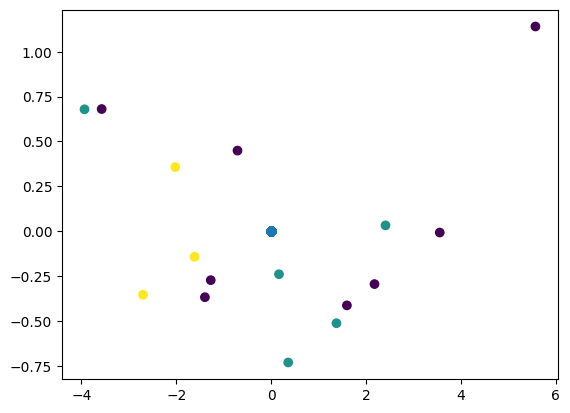

In [115]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_replaced)
plt.scatter(full_cands[:,0], full_cands[:,1])
plt.show()

In [120]:
print(full_cands)
new_experiments = np.concatenate((reverse_one_hot_index(np.argmax(np.random.uniform(size=(full_cands.shape[0],3)), axis=1), values), sc.inverse_transform(full_cands[:,3:])), axis=1)
new_expirments_df = pd.DataFrame(data=new_experiments, columns=full_data.columns[:-1])
print(new_expirments_df)


[[ 0.          0.          1.         ...  0.60604209  0.37346656
   0.63730925]
 [ 0.          0.          1.         ...  0.59521108  0.3680769
   0.63056204]
 [ 0.          0.          1.         ...  0.59641259  0.36660197
   0.62438667]
 ...
 [ 0.          0.          1.         ... -0.80201537 -0.35518495
  -0.33331713]
 [ 0.          0.          1.         ... -0.81764374 -0.34534285
  -0.28420009]
 [ 0.          0.          1.         ... -0.81884526 -0.34386791
  -0.27802472]]
    Sex              Length                Width               Height  \
0     I  0.6727114971756144   0.5125754244156385  0.15644401527301774   
1     F  0.6719891896417045   0.5120425585828625  0.15636283907912804   
2     F  0.6703687695282086   0.5110518472460175  0.15622983974579754   
3     M  0.6699197132384156   0.5108229244939829  0.15620392817607714   
4     F  0.6700955182840918    0.510747904165276  0.15617457512162825   
..   ..                 ...                  ...                  ...  

In [46]:
x_new_acquired = full_cands
used_dict = {"used_x": x_new_acquired[:,0], "used_y": x_new_acquired[:,1]}
print(x_new_acquired)
used_df = pd.DataFrame(used_dict)
used_df.to_csv("used_cands_batch4.csv")
print("inv pca")
new_experiments = pca.inverse_transform(x_new_acquired)
print(new_experiments[:,:3])
print(new_experiments[:,:3].shape)
print(reverseOneHot(new_experiments[:,:3], values))
print(reverseOneHot(new_experiments[:,:3], values).shape)

print(new_experiments[:,3:])
print(new_experiments[:,3:].shape)
new_experiments = np.concatenate((reverse_one_hot_index(np.argmax(new_experiments[:,:3], axis=1), values), sc.inverse_transform(new_experiments[:,3:])), axis=1)
print(new_experiments.shape)
print(new_experiments)
new_expirments_df = pd.DataFrame(data=new_experiments, columns=full_data.columns[:-1])
#new_expirments_df = pd.DataFrame(data=new_experiments.T)
print(new_expirments_df)
new_expirments_df.to_csv("FourthBatch.csv")

[[-3.03355705  1.93288591]
 [-2.76510067  1.93288591]
 [-2.89932886  1.93288591]
 [-2.09395973  2.21812081]
 [-3.03355705  1.87583893]
 [-4.37583893 -2.80201342]
 [-4.37583893 -2.8590604 ]
 [-4.37583893 -2.91610738]
 [-3.83892617  0.84899329]
 [-4.37583893 -2.97315436]
 [-4.37583893 -3.03020134]
 [-6.12080537 -2.97315436]
 [-6.12080537 -2.8590604 ]
 [-3.83892617  0.90604027]
 [-6.25503356 -2.8590604 ]
 [-6.52348993 -2.97315436]
 [-6.12080537 -2.80201342]
 [-6.25503356 -2.80201342]
 [-6.38926174 -2.80201342]
 [-6.52348993 -2.80201342]
 [-6.38926174 -2.97315436]
 [-6.25503356 -2.97315436]
 [-6.38926174 -2.8590604 ]
 [-6.52348993 -2.91610738]
 [-6.38926174 -2.91610738]
 [-2.76510067  1.87583893]
 [-6.12080537 -2.91610738]
 [-6.25503356 -2.91610738]
 [-6.52348993 -2.8590604 ]
 [-2.36241611  2.21812081]
 [-6.52348993 -3.03020134]
 [-6.38926174 -3.03020134]
 [-2.89932886  1.87583893]
 [-6.25503356 -3.03020134]
 [-3.70469799  0.84899329]
 [-6.12080537 -3.03020134]
 [ 6.63087248  0.50671141]
 

Was ich am 6.7. gelernt habe:
1. Mein Datensatz besteht aus [640, 194, 28] [Adult, adole, child] und [544, 61, 257] [F, I, M]
2. Wenn man die PCA von allen Cands vom Standartisierten Datensatz zurück transformiert, gibt es keine Inter mehr. (Davor anscheinend schon, scheint was mit der standartisierung zu tun zu haben)
3. Wenn man das MLP auf den daten dieser Kandidaten im original format (inverse pca) trainiert gibt es einfach immer Adult aus (~99%).

Dinge davor:
1. Alles normalverteilt
2. Scuffed Pca mit onehot ohne standartisierung -> baysian optimization for mlp -> reverse
3. Scuffed PCA mit onehot und standartisierung -> baysian optimization for mlp -> reverse
4. ? 

Sexes sollten keinen EInfluss auf das Ergebnis haben (glaube ich). Zumindest sollten sie nicht ausschlaggebend sein.

[[ 1.          0.          0.         ... -1.21641639 -0.94720341
  -1.14265086]
 [ 1.          0.          0.         ... -1.20194939 -0.49569798
  -0.47090362]
 [ 0.          0.          1.         ...  1.22850674  1.90905916
   1.76394777]
 ...
 [ 0.          0.          1.         ... -0.25053149 -0.24235763
  -0.24281549]
 [ 1.          0.          0.         ...  0.27155386  0.27704853
   0.27185656]
 [ 0.          0.          1.         ... -0.29349563 -0.28501577
  -0.28511794]]
(580, 10)
[0.69096185 0.11797633]
[54.99610122 22.72491743]
11.697543430954404
3.9241258731927884
-7.729254717549433
-3.509708334680696


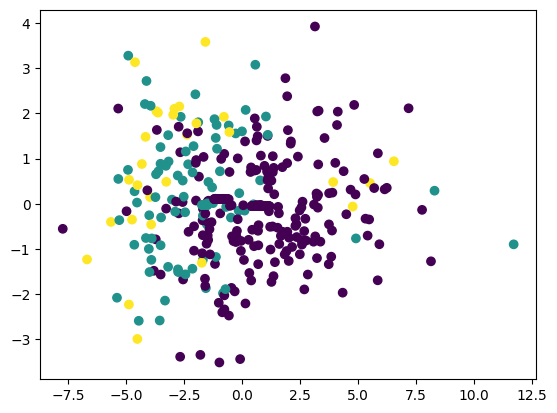

In [77]:


values = np.sort(np.unique(full_data["Sex"]))

sc = preprocessing.StandardScaler().fit(full_data.values[:,1:-1])
numeric_transf = sc.transform(full_data.values[:,1:-1])

x = np.concatenate((getOneHotEncoding(full_data["Sex"], values), numeric_transf), axis=1)
print(x)

print(x.shape)
#print(x_full_replaced)

pca = PCA(2)
pca = pca.fit(x)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

x_pca = pca.transform(x)
print(x_pca[:,0].max())
print(x_pca[:,1].max())
print(x_pca[:,0].min())
print(x_pca[:,1].min())

plt.scatter(x_pca[:,0], x_pca[:,1], c=y_replaced)
plt.show()

In [79]:
full_data = loadFullData()
y = full_data["Stage of Life"]


values = np.sort(np.unique(full_data["Sex"]))

sc = preprocessing.StandardScaler().fit(full_data.values[:,1:-1])
numeric_transf = sc.transform(full_data.values[:,1:-1])

x = np.concatenate((getOneHotEncoding(full_data["Sex"], values), numeric_transf), axis=1)

y_replaced = y.replace("Adult",0).replace("Adole",1).replace("Child",2)

pca = PCA(2)
pca = pca.fit(x)

x_pca = pca.transform(x)
print(x_pca[:,0].max())
print(x_pca[:,1].max())
print(x_pca[:,0].min())
print(x_pca[:,1].min())

x_acquired = x_pca
y_acquired_rfc = objectiveFunctionRFC(x_acquired, y_replaced)
#print(y_acquired_rfc)
y_acquired_svc = objectiveFunctionSVC(x_acquired, y_replaced)
#print(y_acquired_svc)
y_acquired_mlp = objectiveFunctionMLP(x_acquired, y)
#print(y_acquired_mlp)

metrics_dict = {'gamma': 50, 'metric': 'rbf'}
gpr = GaussianProcessRegression(metrics_dict=metrics_dict)
gpr.fit(x_acquired, y_acquired_mlp)


x_new = np.linspace(-8, 12, 150)
y_new = np.linspace(-4, 4.5, 150)
x_mesh, y_mesh = np.meshgrid(x_new, y_new)
x_cand = np.stack((x_mesh, y_mesh), axis=2).reshape(-1,2)
means, stds = gpr.predict(x_cand, True)
scores = acquisition_ei(means, stds, max(y_acquired_mlp))
print(scores)
print(scores.mean())
print(scores.std())
print(scores.min())
print(scores.max())

nextidx = np.argsort(scores)
print("scores")
print(scores[nextidx[:282]])
print("cands")

x_new_acquired = x_cand[nextidx[:282]]
used_dict = {"used_x": x_new_acquired[:,0], "used_y": x_new_acquired[:,1]}
print(x_new_acquired)
used_df = pd.DataFrame(used_dict)
used_df.to_csv("used_cands_batch3.csv")
print("inv pca")
new_experiments = pca.inverse_transform(x_new_acquired)
print(new_experiments[:,:3])
print(new_experiments[:,:3].shape)
print(reverseOneHot(new_experiments[:,:3], values))
print(reverseOneHot(new_experiments[:,:3], values).shape)

print(new_experiments[:,3:])
print(new_experiments[:,3:].shape)
new_experiments = np.concatenate((reverse_one_hot_index(np.argmax(new_experiments[:,:3], axis=1), values), sc.inverse_transform(new_experiments[:,3:])), axis=1)
print(new_experiments.shape)
print(new_experiments)
#new_expirments_df = pd.DataFrame(data=new_experiments, columns=full_data.columns[:-1])
new_expirments_df = pd.DataFrame(data=new_experiments.T)
print(new_expirments_df)
new_expirments_df.to_csv("ThirdBatch.csv")
print()




11.697543430954402
3.9241258731927893
-7.729254717549433
-3.5097083346806977
[0.59459236 0.59459236 0.59459236 ... 0.59459236 0.59459236 0.59459236]
0.5566267788718046
0.10241767128757862
1.804497757677912e-14
0.9948871355704824
scores
[1.80449776e-14 1.87658489e-09 4.23180093e-09 4.34451399e-08
 2.58233831e-07 1.55750564e-06 3.58003284e-06 1.10531199e-05
 2.56075195e-05 3.47738922e-05 5.68603450e-05 6.40357140e-05
 7.22032128e-05 7.92168631e-05 8.65822814e-05 8.78982311e-05
 8.79238478e-05 4.04850635e-04 5.28640092e-04 5.32502581e-04
 5.64192281e-04 7.35111611e-04 7.38904858e-04 1.29562793e-03
 1.39155579e-03 1.48536668e-03 1.49630004e-03 1.62352061e-03
 1.74835631e-03 1.88884648e-03 1.99336086e-03 2.09939105e-03
 2.40942802e-03 3.07594120e-03 3.27872641e-03 3.39704475e-03
 3.44769725e-03 3.69577384e-03 4.07941304e-03 4.11901994e-03
 4.39400990e-03 4.44536760e-03 4.81392972e-03 6.28975364e-03
 6.51817873e-03 6.75817659e-03 7.90425420e-03 8.12578503e-03
 8.46240417e-03 8.84316074e-03 9